# EfficientNet
- model : EfficientNet-B7
- Image Size : 600 x 600
- Image Augmentation
- Epochs : 20
- loss : CrossEntropyLoss
- optimizer : AdamW

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install efficientnet-pytorch==0.7.1 googlemaps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=749ea05d6cbc9d8fe86a6bb6f51fde1bb0ad8f0ee034ab303d0ce1e4e8bc159c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for googlemaps: filename=googlemaps-4.10.0-py3-none-any.whl size=40718 sha256=93ea04643b0107077b9305ecd571b060a9648e526cd0e0a2a7578a87431e9834
  Stored in directory: /root/.cache/pip/wheels/17/f8/79/999d5d37118fd35d7219ef57933eb9d09886c4c4503a800f84
Successfully built efficientnet-pytorch googlemaps


In [3]:
import pandas as pd
import numpy as np
import random
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from tqdm.notebook import tqdm

import joblib
import h5py

import googlemaps
import requests

import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

data_path = ("/content/drive/MyDrive/2023/YS/Python_Colab/fireforest_EfficientNet/")
api_key = "key"

In [4]:
def get_service_key(servicekey_path, key_name):
    """
    주어진 서비스 키 파일에서 지정된 키 이름에 해당하는 서비스 키를 반환합니다.

    Args:
        servicekey_path (str): 서비스 키 파일의 경로.
        key_name (str): 반환할 서비스 키의 이름.

    Returns:
        str or None: 지정된 키 이름에 해당하는 서비스 키. 키를 찾을 수 없는 경우 None을 반환합니다.
    """

    with open(servicekey_path) as f:
        data = json.load(f)
        service_key = data.get(key_name)
    return service_key

In [5]:
def show_image(img_names, rows=2, cols=3):
    """
    지정된 이미지 파일들을 그리드 형태로 출력합니다.

    Args:
        img_names (list): 출력할 이미지 파일명 리스트
        rows (int, optional): 출력할 행(row) 개수 (기본값: 2)
        cols (int, optional): 출력할 열(column) 개수 (기본값: 3)
    """
    assert len(img_names) <= rows*cols

    plt.figure(figsize=(15, 8))
    grid = gridspec.GridSpec(rows, cols)

    for idx, img_name in enumerate(img_names):
        img_path = f"{data_path}/img/{img_name}"
        image = cv2.imread(img_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

# EDA

In [6]:
train = pd.read_csv(data_path + "/img.csv")

In [7]:
train.shape

(311, 7)

In [8]:
train

,image_name,spring_mountain,summer_mountain,autumn_mountain,winter_mountain,forestfires_occur_early,forestfires_occur
0,img0.jpg,1,0,0,0,0,0
1,img1.jpg,1,0,0,0,0,0
2,img2.jpg,1,0,0,0,0,0
3,img3.jpg,1,0,0,0,0,0
4,img4.jpg,1,0,0,0,0,0
...,...,...,...,...,...,...,...
306,img294.jpg,0,0,0,0,0,1
307,img295.jpg,0,0,0,0,0,1
308,img322.jpg,0,0,0,0,0,1
309,img323.jpg,0,0,0,0,0,1


In [9]:
spring_mountain = train.loc[train["spring_mountain"]==1]
summer_mountain = train.loc[train["summer_mountain"]==1]
autumn_mountain = train.loc[train["autumn_mountain"]==1]
winter_mountain = train.loc[train["winter_mountain"]==1]
forestfires_occur_early = train.loc[train["forestfires_occur_early"]==1]
forestfires_occur = train.loc[train["forestfires_occur"]==1]

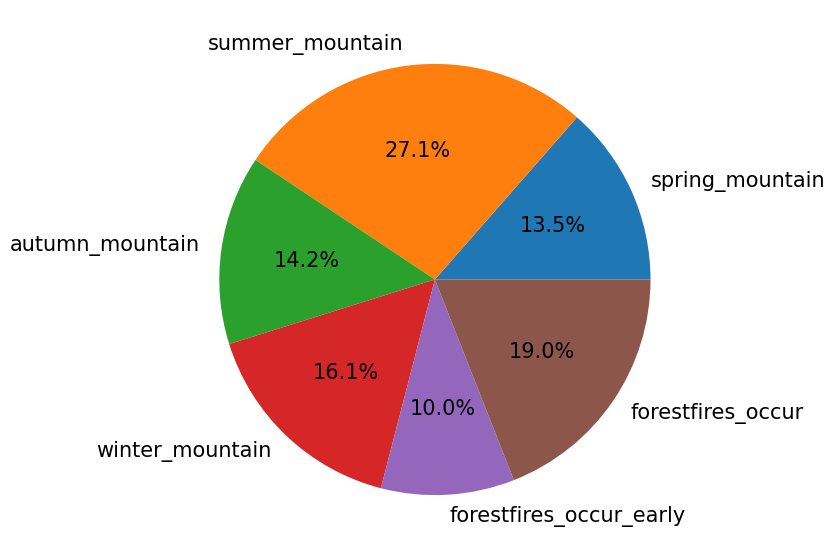

In [10]:
%matplotlib inline

mpl.rc("font", size=15)
plt.figure(figsize=(7, 7))

label = ["spring_mountain", "summer_mountain", "autumn_mountain", "winter_mountain", "forestfires_occur_early", "forestfires_occur"]

plt.pie([len(spring_mountain), len(summer_mountain), len(autumn_mountain), len(winter_mountain), len(forestfires_occur_early), len(forestfires_occur)], labels=label, autopct="%.1f%%");

In [11]:
num_of_imgs = 12

spring_mountain_img	= spring_mountain["image_name"][-num_of_imgs:]
summer_mountain_img	= summer_mountain["image_name"][-num_of_imgs:]
autumn_mountain_img	= autumn_mountain["image_name"][-num_of_imgs:]
winter_mountain_img	= winter_mountain["image_name"][-num_of_imgs:]
forestfires_occur_early_img	= forestfires_occur_early["image_name"][-num_of_imgs:]
forestfires_occur_img	= forestfires_occur["image_name"][-num_of_imgs:]

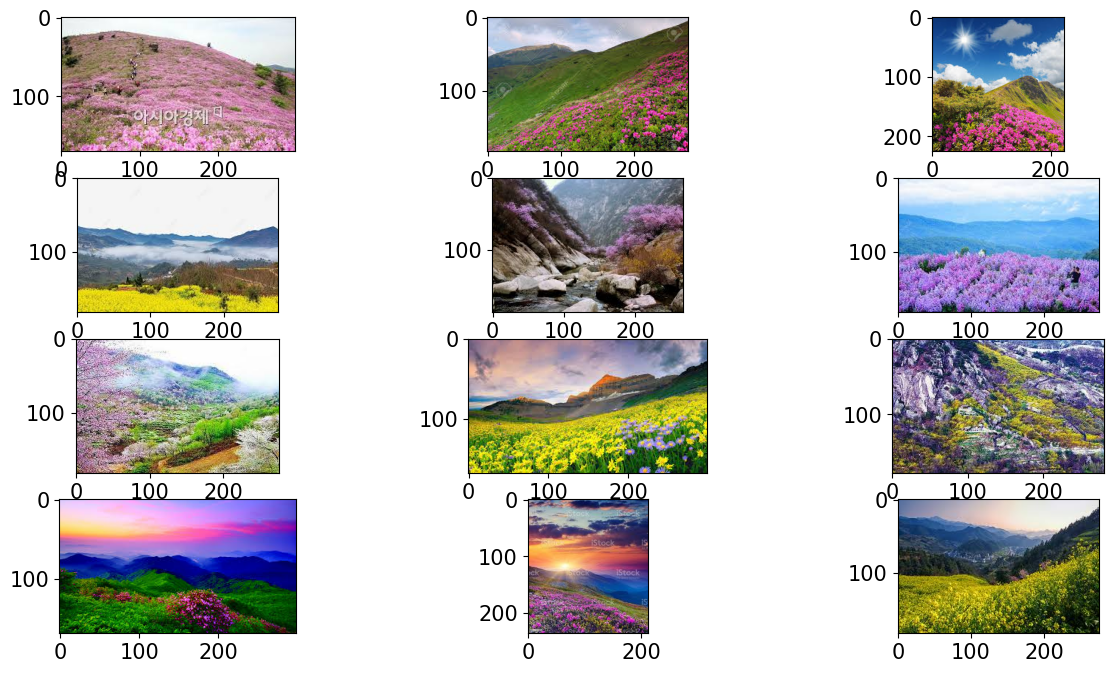

In [12]:
show_image(spring_mountain_img, rows=4, cols=3)

# Train

In [13]:
seed = 50
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
train, valid = train_test_split(train, test_size=0.1, random_state=50)

In [16]:
class ImageDataset(Dataset):
    """
    이미지 데이터셋 클래스입니다.
    """
    def __init__(self, df, img_dir="./", transform=None, is_test=False):
        """
        이미지 파일과 해당 이미지의 레이블 정보를 포함합니다.

        Args:
            df (pandas.DataFrame): 이미지 파일과 레이블 정보가 담긴 데이터프레임
            img_dir (str, optional): 이미지 파일이 위치한 디렉토리 경로 (기본값: "./")
            transform (callable, optional): 이미지 변환을 위한 변환 함수 (기본값: None)
            is_test (bool, optional): 테스트 데이터셋인지 여부 (기본값: False)
        """
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        """
        데이터셋의 샘플 개수를 반환합니다.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 샘플을 반환합니다.

        Args:
            idx (int): 샘플 인덱스

        Returns:
            image (numpy.ndarray or torch.Tensor): 이미지 데이터
            label (int, optional): 이미지의 레이블 정보 (훈련 데이터셋인 경우만 반환)
        """

        img_name = self.df.iloc[idx, 0]
        img_path = self.img_dir + img_name

        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform is not None:
                image = self.transform(image=image)["image"]

            if self.is_test:
                return image
            else:
                label = np.argmax(self.df.iloc[idx, 1:7])
                return image, label

        except Exception as e:
            print(f"Error loading image: {img_path}")
            print(f"Exception: {e}")
            return None

In [17]:
transform_train = A.Compose([
    A.Resize(600, 600),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1), A.Sharpen(p=1), A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3),
    A.Normalize(),
    ToTensorV2()
    ])

transform_test = A.Compose([
    A.Resize(600, 600),
    A.Normalize(),
    ToTensorV2()
    ])

In [18]:
img_dir = data_path + "/img/"

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [19]:
len(dataset_train), len(dataset_valid)

(279, 32)

In [20]:
def seed_worker(worker_id):
    """
    워커(worker)의 시드를 설정하는 함수입니다.
    워커의 시드는 전체 시드에서 워커 ID에 기반하여 생성됩니다.

    Args:
        worker_id (int): 워커 ID

    Returns:
        None
    """

    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [21]:
batch_size = 2

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [22]:
model = EfficientNet.from_pretrained("efficientnet-b7", num_classes=6)
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:14<00:00, 18.3MB/s]


Loaded pretrained weights for efficientnet-b7


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.0001)

In [24]:
epochs = 20
train_losses = []
valid_losses = []
roc_auc_values = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0

    for images, labels in tqdm(loader_train):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = epoch_train_loss / len(loader_train)
    train_losses.append(train_loss)
    print(f"에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {train_loss:.4f}")

    model.eval()
    epoch_valid_loss = 0
    preds_list = []
    true_onehot_list = []

    with torch.no_grad():
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()

            preds = torch.softmax(outputs.cpu(), dim=1).numpy()
            true_onehot = torch.eye(6)[labels.cpu()].numpy()
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)

    valid_loss = epoch_valid_loss / len(loader_valid)
    valid_losses.append(valid_loss)
    roc_auc = roc_auc_score(true_onehot_list, preds_list)
    roc_auc_values.append(roc_auc)
    print(f"에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {valid_loss:.4f} / 검증 데이터 ROC AUC : {roc_auc:.4f}")

print("=======================================================================")
print("최종 모델의 ROC AUC:", roc_auc)

  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [1/20] - 훈련 데이터 손실값 : 1.6034
에폭 [1/20] - 검증 데이터 손실값 : 1.4902 / 검증 데이터 ROC AUC : 0.7607


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [2/20] - 훈련 데이터 손실값 : 1.5002
에폭 [2/20] - 검증 데이터 손실값 : 1.6416 / 검증 데이터 ROC AUC : 0.7265


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [3/20] - 훈련 데이터 손실값 : 1.3572
에폭 [3/20] - 검증 데이터 손실값 : 9.7265 / 검증 데이터 ROC AUC : 0.6023


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [4/20] - 훈련 데이터 손실값 : 1.2899
에폭 [4/20] - 검증 데이터 손실값 : 5.5300 / 검증 데이터 ROC AUC : 0.6071


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [5/20] - 훈련 데이터 손실값 : 1.2052
에폭 [5/20] - 검증 데이터 손실값 : 1.9967 / 검증 데이터 ROC AUC : 0.7476


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [6/20] - 훈련 데이터 손실값 : 1.1651
에폭 [6/20] - 검증 데이터 손실값 : 0.7489 / 검증 데이터 ROC AUC : 0.9450


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [7/20] - 훈련 데이터 손실값 : 1.1951
에폭 [7/20] - 검증 데이터 손실값 : 1.2521 / 검증 데이터 ROC AUC : 0.8237


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [8/20] - 훈련 데이터 손실값 : 1.0316
에폭 [8/20] - 검증 데이터 손실값 : 1.0134 / 검증 데이터 ROC AUC : 0.9264


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [9/20] - 훈련 데이터 손실값 : 0.9338
에폭 [9/20] - 검증 데이터 손실값 : 0.6644 / 검증 데이터 ROC AUC : 0.9565


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [10/20] - 훈련 데이터 손실값 : 0.9512
에폭 [10/20] - 검증 데이터 손실값 : 0.5426 / 검증 데이터 ROC AUC : 0.9541


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [11/20] - 훈련 데이터 손실값 : 0.8429
에폭 [11/20] - 검증 데이터 손실값 : 0.7874 / 검증 데이터 ROC AUC : 0.9336


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [12/20] - 훈련 데이터 손실값 : 0.7613
에폭 [12/20] - 검증 데이터 손실값 : 0.4909 / 검증 데이터 ROC AUC : 0.9751


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [13/20] - 훈련 데이터 손실값 : 0.8837
에폭 [13/20] - 검증 데이터 손실값 : 1.1943 / 검증 데이터 ROC AUC : 0.8780


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [14/20] - 훈련 데이터 손실값 : 0.7535
에폭 [14/20] - 검증 데이터 손실값 : 2.0868 / 검증 데이터 ROC AUC : 0.8874


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [15/20] - 훈련 데이터 손실값 : 0.6131
에폭 [15/20] - 검증 데이터 손실값 : 1.3216 / 검증 데이터 ROC AUC : 0.8633


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [16/20] - 훈련 데이터 손실값 : 0.6344
에폭 [16/20] - 검증 데이터 손실값 : 1.9790 / 검증 데이터 ROC AUC : 0.7957


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [17/20] - 훈련 데이터 손실값 : 0.6191
에폭 [17/20] - 검증 데이터 손실값 : 1.3311 / 검증 데이터 ROC AUC : 0.9206


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [18/20] - 훈련 데이터 손실값 : 0.7054
에폭 [18/20] - 검증 데이터 손실값 : 1.8934 / 검증 데이터 ROC AUC : 0.8516


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [19/20] - 훈련 데이터 손실값 : 0.7025
에폭 [19/20] - 검증 데이터 손실값 : 0.6255 / 검증 데이터 ROC AUC : 0.9661


  0%|          | 0/140 [00:00<?, ?it/s]

에폭 [20/20] - 훈련 데이터 손실값 : 0.4131
에폭 [20/20] - 검증 데이터 손실값 : 0.6389 / 검증 데이터 ROC AUC : 0.9588
최종 모델의 ROC AUC: 0.9588474025974026


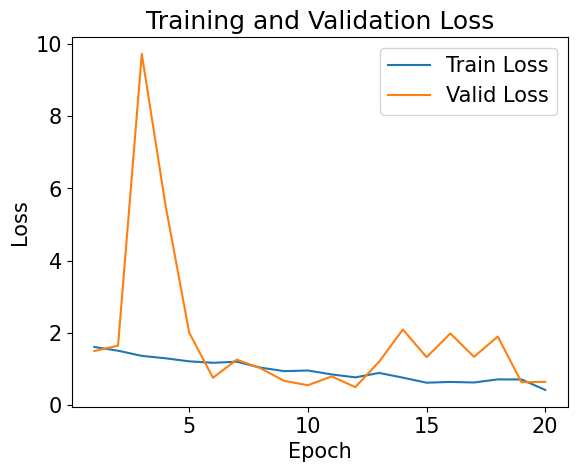

In [25]:
# Loss 그래프 그리기
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

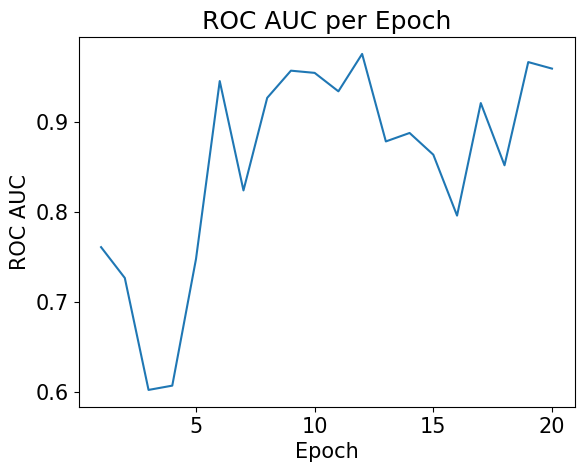

In [26]:
# ROC AUC 그래프 그리기
plt.plot(range(1, epochs+1), roc_auc_values)
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('ROC AUC per Epoch')
plt.show()

In [27]:
# 모델 저장
joblib.dump(model, data_path + 'EfficientNet.pkl')

['/content/drive/MyDrive/2023/YS/Python_Colab/fireforest_EfficientNet/EfficientNet.pkl']

# Simulation

In [28]:
def get_current_location(api_key):
    """
    현재 위치의 위도(latitude)와 경도(longitude)를 가져오는 함수입니다.

    Args:
        api_key (str): Google Maps API 키

    Returns:
        tuple or None: 현재 위치의 위도와 경도 (latitude, longitude)
                       가져오지 못한 경우 None을 반환합니다.
    """

    gmaps = googlemaps.Client(key=api_key)

    try:
        location = gmaps.geolocate()
        latitude = location["location"]["lat"]
        longitude = location["location"]["lng"]
        return latitude, longitude
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

In [29]:
def reverse_geocode(latitude, longitude, api_key):
    """
    주어진 위도(latitude)와 경도(longitude)를 기반으로 지오코딩을 수행하여 주소를 가져오는 함수입니다.

    Args:
        latitude (float): 위도 값
        longitude (float): 경도 값
        api_key (str): Google Maps API 키

    Returns:
        str or None: 주어진 위도와 경도에 대한 주소 정보
                     가져오지 못한 경우 None을 반환합니다.
    """
    url = f'https://maps.googleapis.com/maps/api/geocode/json?latlng={latitude},{longitude}&key={api_key}&language=ko'
    response = requests.get(url)
    data = response.json()

    if data['results']:
        address = data['results'][0]['formatted_address']
        return address

    return None

In [30]:
def inference(model, image_path):
    """
    주어진 이미지에 대해 모델을 통해 예측을 수행하고 결과를 출력하는 함수입니다.

    Args:
        model (torch.nn.Module): 사용할 모델
        image_path (str): 이미지 파일 경로

    Returns:
        str: 예측 결과로 얻은 주소 정보
    """
    model.eval()
    transform = A.Compose([
        A.Resize(600, 600),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
        A.VerticalFlip(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.3),
        A.OneOf([A.Emboss(p=1), A.Sharpen(p=1), A.Blur(p=1)], p=0.3),
        A.PiecewiseAffine(p=0.3),
        A.Normalize(),
        ToTensorV2()
        ])

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    preprocessed_image = transform(image=image)["image"]
    preprocessed_image = preprocessed_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(preprocessed_image)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    class_names = ["spring_mountain", "summer_mountain", "autumn_mountain", "winter_mountain", "forestfires_occur_early", "forestfires_occur"]

    predicted_label = class_names[predicted_class]
    predicted_probs = probabilities.squeeze().cpu().numpy()

    location = get_current_location(api_key)
    latitude, longitude = location

    address = reverse_geocode(latitude, longitude, api_key)

    print("=================================================")
    top2_labels = [class_names[i] for i in np.argsort(predicted_probs)[-2:]]
    if "forestfires_occur_early" in top2_labels or "forestfires_occur" in top2_labels:
        print("WARNING: Forest fires occur suspected!")
        print("=================================================")
        print(f"{address}, ({latitude}, {longitude})")
        print("=================================================")

    else:
        print("Non Forest fires occur suspected.")
        print("=================================================")
        print(f"{address}, ({latitude}, {longitude})")
        print("=================================================")

    print("Predicted Class and Probabilities:")
    for label, prob in zip(class_names, predicted_probs):
        print(f"{label}: {prob*100:.2f}%")

    plt.imshow(image)
    plt.title(predicted_label)
    plt.axis("off")
    plt.show()

    return address

In [31]:
model = joblib.load(data_path + 'EfficientNet.pkl')
simulation = pd.read_csv(data_path + "/simulation.csv")

9R29+RW 싱가포르, (1.352083, 103.819836)
Predicted Class and Probabilities:
spring_mountain: 0.00%
summer_mountain: 0.00%
autumn_mountain: 0.00%
winter_mountain: 0.02%
forestfires_occur_early: 99.43%
forestfires_occur: 0.55%


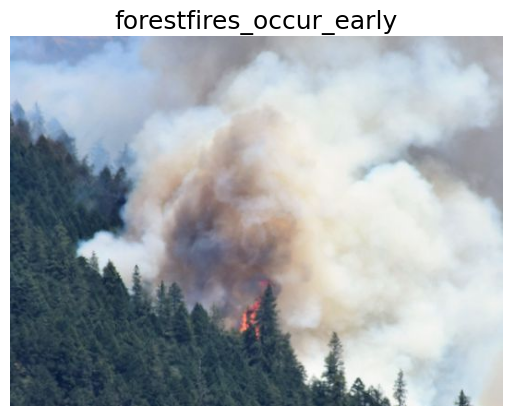

'9R29+RW 싱가포르'

In [38]:
random_number = random.randint(0, 19)

image_path = data_path + '/simulation/' + simulation["image_name"][random_number]
inference(model, image_path)